In [81]:
# data manipulation
import pandas as pd
import numpy as np

# pre processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import xgboost as xgb

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# saving
import joblib

# progress monitoring
from tqdm import tqdm

In [4]:
X_train = joblib.load('../data/X_train.pkl')
y_train = joblib.load('../data/y_train.pkl')

X_train.shape, y_train.shape

((36249, 18), (36249,))

In [14]:
map_func = np.vectorize(lambda x: 0 if x == 'DOWN' else 1)
y_train = map_func(y_train)

In [16]:
joblib.dump(y_train, '../data/y_train.pkl')

['../data/y_train.pkl']

In [11]:
pd.set_option('display.max_columns', None)

In [5]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [6]:
model = xgb.XGBClassifier(random_state=42)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [7]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7, None],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

In [63]:
pipeline_param_grid = {
    'xgb__n_estimators': [100, 200, 300, 500],
    'xgb__max_depth': [3, 4, 5, 6, 7, None],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__subsample': [0.7, 0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'xgb__gamma': [0, 0.1, 0.2, 0.3],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__reg_alpha': [0, 0.01, 0.1, 1],
    'xgb__reg_lambda': [1, 1.5, 2]
}

In [9]:
def train_random_search(X, y, estimator, grid, n_iter=20):
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=grid,
        cv=skf,
        scoring=scoring,
        refit='f1_macro',
        n_jobs=-1,
        return_train_score=True,
        verbose=0,
        n_iter=n_iter
    )

    
    with tqdm(total=n_iter, desc="RandomizedSeachCV Progress") as pbar:
        random_search.fit(X, y)
        pbar.update(n_iter)

    return random_search

In [10]:
def get_results(r_search, pipeline=False):
    results = pd.DataFrame(r_search.cv_results_)
    
    if pipeline:
        results = results[
            [
                'mean_fit_time', 'mean_score_time', 'param_xgb__n_estimators', 'param_xgb__max_depth', 'param_xgb__learning_rate', 'param_xgb__subsample',
                'param_xgb__colsample_bytree', 'param_xgb__gamma', 'param_xgb__min_child_weight', 'param_xgb__reg_alpha', 'param_xgb__reg_lambda', 'mean_train_accuracy', 
                'mean_test_accuracy', 'rank_test_accuracy', 
                'mean_train_precision_macro', 'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 
                'mean_test_recall_macro', 'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
            ]
        ]
    else:
        results = results[
            [
                'mean_fit_time', 'mean_score_time', 'param_n_estimators', 'param_max_depth', 'param_learning_rate', 'param_subsample',
                'param_colsample_bytree', 'param_gamma', 'param_min_child_weight', 'param_reg_alpha', 'param_reg_lambda', 'mean_train_accuracy', 
                'mean_test_accuracy', 'rank_test_accuracy', 
                'mean_train_precision_macro', 'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 
                'mean_test_recall_macro', 'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
            ]
        ]


    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [18]:
rs = train_random_search(X_train, y_train, model, param_grid, 100)

RandomizedSeachCV Progress: 100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


In [19]:
results = get_results(rs)
results.head()

,mean_fit_time,mean_score_time,param_n_estimators,param_max_depth,param_learning_rate,param_subsample,param_colsample_bytree,param_gamma,param_min_child_weight,param_reg_alpha,param_reg_lambda,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
85,3.815206,0.117605,500,7,0.1,0.9,0.9,0.0,3,1.00,1.0,0.987748,0.951447,1,0.987347,0.950193,1,0.987586,0.950554,1,0.987466,0.950341,1
45,3.390739,0.120300,500,7,0.1,1.0,0.9,0.0,3,1.00,1.5,0.985728,0.951171,2,0.985281,0.949898,2,0.985520,0.950297,2,0.985399,0.950061,2
63,3.355498,0.097000,500,6,0.1,0.7,0.9,0.1,1,0.00,1.5,0.983598,0.950564,3,0.983103,0.949212,3,0.983338,0.949735,3,0.983220,0.949447,3
97,1.582586,0.065318,300,None,0.2,1.0,1.0,0.1,3,1.00,1.5,0.979601,0.949212,4,0.979002,0.947833,4,0.979263,0.948356,4,0.979131,0.948063,4
55,2.084946,0.069800,300,6,0.2,0.8,1.0,0.3,3,0.01,2.0,0.981967,0.948274,5,0.981436,0.946884,5,0.981668,0.947380,5,0.981551,0.947104,5


In [45]:
def view_test_metrics(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame, pipeline: bool=False):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    if pipeline:
        param_cols = [
        'param_xgb__n_estimators', 'param_xgb__max_depth', 'param_xgb__learning_rate', 'param_xgb__subsample',
        'param_xgb__colsample_bytree', 'param_xgb__gamma', 'param_xgb__min_child_weight', 'param_xgb__reg_alpha', 'param_xgb__reg_lambda'
    ]
    else:
        param_cols = [
        'param_n_estimators', 'param_max_depth', 'param_learning_rate', 'param_subsample',
        'param_colsample_bytree', 'param_gamma', 'param_min_child_weight', 'param_reg_alpha', 'param_reg_lambda'
    ]


    plot_df = results_df.melt(
        id_vars=param_cols,      # keep these columns "as is"
        value_vars=metrics,      # the columns we want to "unpivot"
        var_name="metric",       # new column with the metric name
        value_name="score"       # new column with the metric value
    )

    plt.figure(figsize=(8, 8))
    
    # Group the data by parameter combination and create a list of groups.
    groups = list(plot_df.groupby(param_cols))
    # Create a color palette with as many colors as there are groups.
    colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))
    
    for i, (combo, group) in enumerate(groups):
        group = group.sort_values("metric")
        # Create a label for the model using its parameters.
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        # Pick the color for this group.
        color = colors[i]
        
        # Separate training and test metrics
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]
        
        # Plot training metrics with the same color
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     color=color,
                     label=label_str + " (train)")
        # Plot test metrics with the same color
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     color=color,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

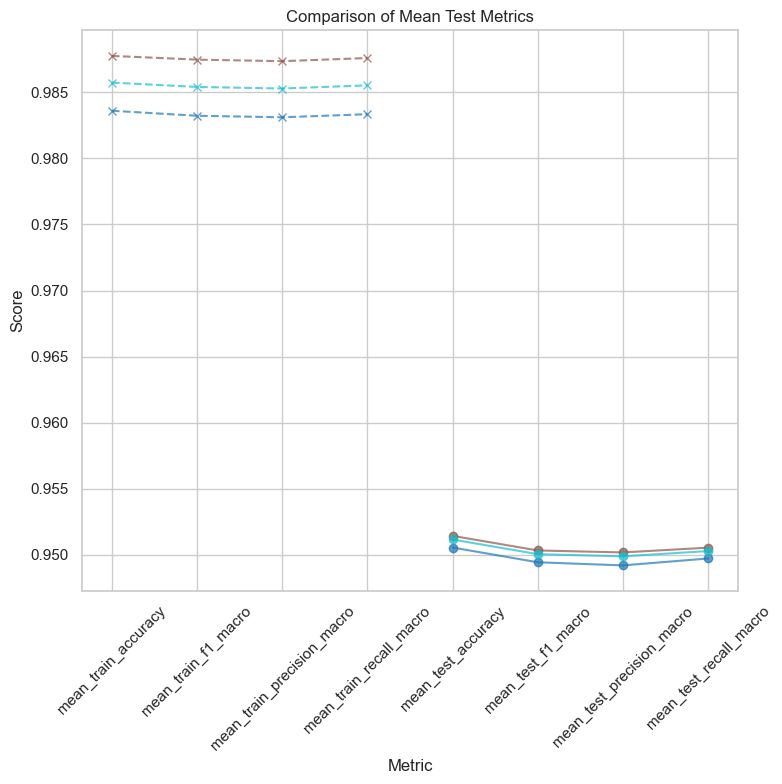

In [46]:
view_test_metrics(True, 3, results)

In [49]:
col_names = joblib.load('../data/cols.pkl')

C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_18236\1360801651.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')


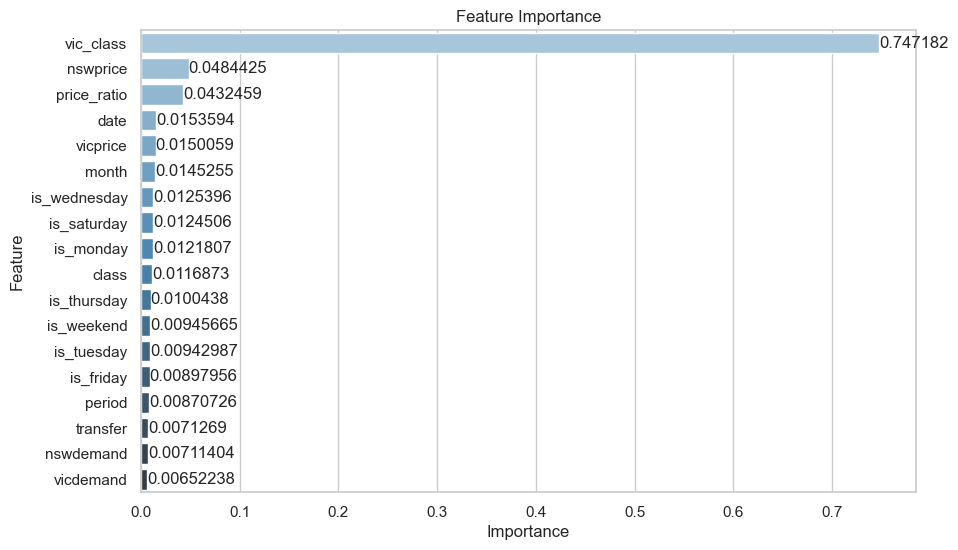

In [69]:
def feature_importance(model):
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': col_names[:-1],
        'Importance': importances
    })

    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')
    for container in ax.containers:
        ax.bar_label(container)
    plt.title('Feature Importance')
    plt.show()
feature_importance(rs.best_estimator_)

### Testando balanceamento

In [64]:
ro_pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ('xgb', xgb.XGBClassifier(random_state=42))
])

In [65]:
ro_rs = train_random_search(X_train, y_train, ro_pipeline, pipeline_param_grid, 100)

RandomizedSeachCV Progress: 100%|██████████| 100/100 [03:20<00:00,  2.01s/it]


In [66]:
ro_results = get_results(ro_rs, True)
ro_results.head()

,mean_fit_time,mean_score_time,param_xgb__n_estimators,param_xgb__max_depth,param_xgb__learning_rate,param_xgb__subsample,param_xgb__colsample_bytree,param_xgb__gamma,param_xgb__min_child_weight,param_xgb__reg_alpha,param_xgb__reg_lambda,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
30,5.324992,0.129503,500,7,0.1,0.7,1.0,0.2,1,0.01,1.5,0.993560,0.953295,1,0.993096,0.951605,1,0.993743,0.953097,1,0.993414,0.952291,1
79,4.758540,0.114296,500,None,0.2,0.8,0.9,0.0,1,1.00,1.5,0.995280,0.953019,2,0.994930,0.951352,2,0.995419,0.952780,2,0.995172,0.952006,2
48,2.728830,0.100159,500,6,0.2,1.0,1.0,0.1,5,0.01,2.0,0.985508,0.950592,3,0.984525,0.948637,3,0.985906,0.950663,3,0.985191,0.949560,3
96,2.422005,0.071462,300,None,0.2,0.8,0.8,0.1,1,0.10,2.0,0.985039,0.950343,4,0.984063,0.948383,5,0.985405,0.950438,4,0.984711,0.949310,4
31,3.063878,0.090706,300,7,0.2,0.7,1.0,0.2,3,1.00,2.0,0.988389,0.950288,5,0.987608,0.948423,4,0.988684,0.950211,5,0.988132,0.949238,5


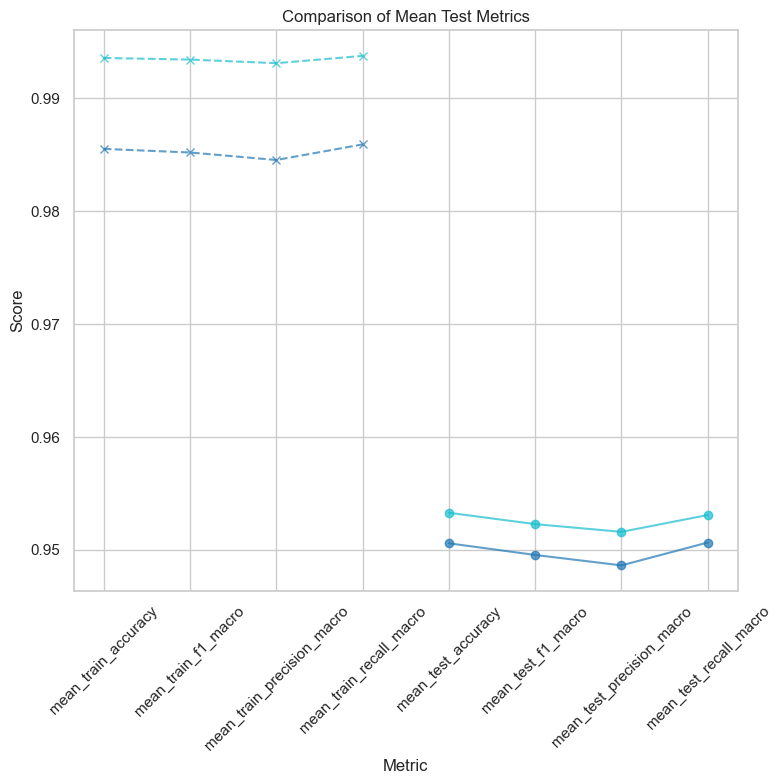

In [68]:
view_test_metrics(True, 3, ro_results, True)

Conseguimos melhorar as métricas com o random oversampling. Agora vamos calcular outras métricas para esse nosso melhor modelo.

C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_18236\1360801651.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')


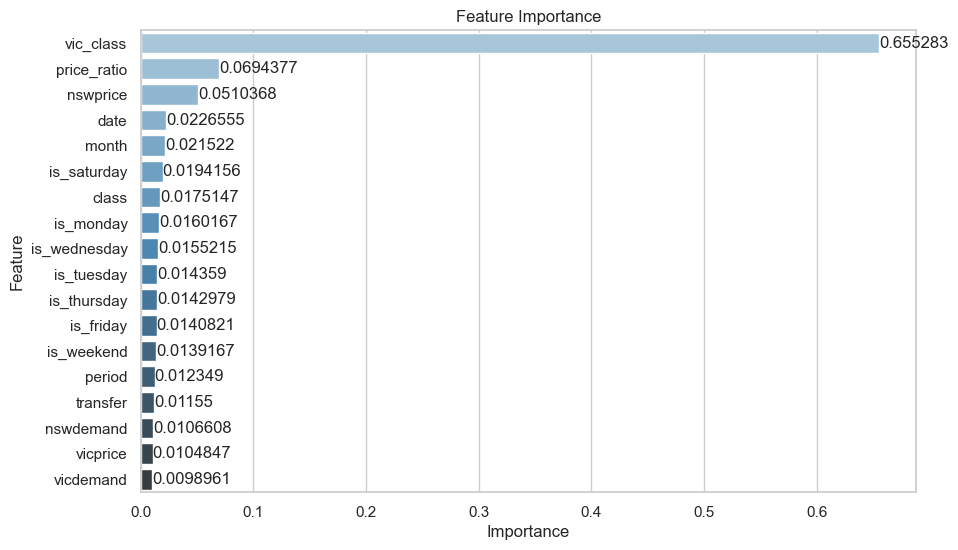

In [71]:
feature_importance(ro_rs.best_estimator_.named_steps['xgb'])

In [72]:
preds = cross_val_predict(ro_rs.best_estimator_, X_train, y_train, cv=skf, n_jobs=-1)

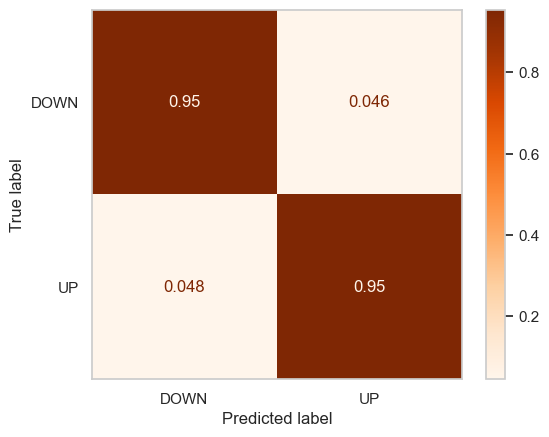

In [79]:
cm = confusion_matrix(y_train, preds, normalize='true')
cmd = ConfusionMatrixDisplay(cm, display_labels=['DOWN', 'UP'])
cmd.plot(cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

In [80]:
print(classification_report(y_train, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9641    0.9544    0.9592     20860
           1     0.9390    0.9518    0.9454     15389

    accuracy                         0.9533     36249
   macro avg     0.9516    0.9531    0.9523     36249
weighted avg     0.9534    0.9533    0.9533     36249



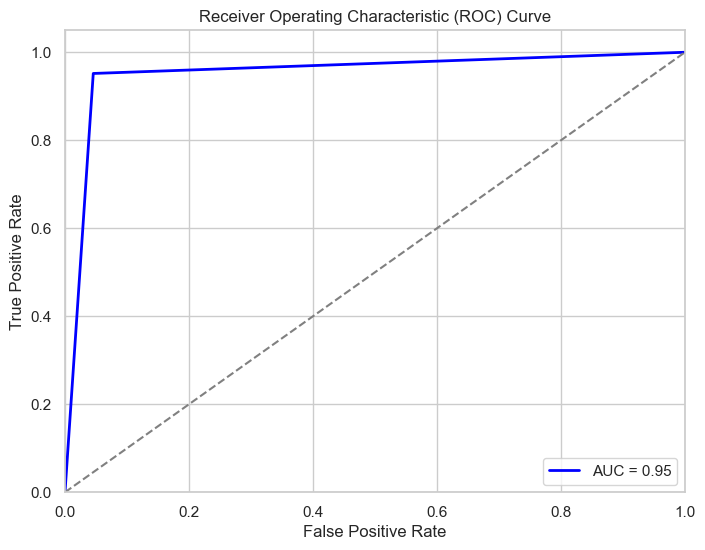

In [82]:
fpr, tpr, thresholds = roc_curve(y_train, preds)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [83]:
joblib.dump(ro_rs.best_estimator_.named_steps['xgb'], '../models/xgb.pkl')

['../models/xgb.pkl']